<a href="https://colab.research.google.com/github/DIFACQUIM/Cursos/blob/main/7_2_Similarity_function_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Similarity Matrix**
---
Made by: Brayan Raziel Cedillo González and Karen Pelcastre

Contact: brayanraziel1997@gmail.com

**Last Update:** March 2025


#Contents
---

>[Similarity Matrix](#scrollTo=hiFhrn25-dOn)

>[Contents](#scrollTo=RsoKYOCQ4iSG)

>[1. Libraries: install and import](#scrollTo=hhoitJyAKLfw)

>[2. Lecture of the database](#scrollTo=Wqonx8417qzp)

>[3. Selection of the similarity function](#scrollTo=eybw3lho7t49)

>[4. Identity plot](#scrollTo=A_qYmjipHqcp)

>[For more information:](#scrollTo=KZQJdMg1bxBL)



<a name='0'></a>
# *1. Libraries: install and import*
---

In [ ]:
from IPython.utils import io
import tqdm.notebook
import os, os.path, sys, random, subprocess
total = 100
with tqdm.notebook.tqdm(total=total) as pbar:
    with io.capture_output() as captured:
        pbar.update(20)
        #Graphic libraries
        !pip install matplotlib
        import matplotlib.pyplot as plt
        import matplotlib.font_manager as font_manager
        %matplotlib inline
        import time

        !pip install seaborn
        import seaborn as sns
        pbar.update(40)
        #System libraries and main tools:
        import pandas as pd
        import warnings
        warnings.filterwarnings("ignore")
        %config Completer.use_jedi = False
        pbar.update(30)

        #Search
        !pip install rdkit
        from rdkit import Chem, DataStructs
        from rdkit.DataStructs import TanimotoSimilarity, DiceSimilarity, CosineSimilarity
        from rdkit.Chem import AllChem, Draw, PandasTools, Descriptors, Descriptors3D, rdMolDescriptors, Scaffolds
        from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
        PandasTools.RenderImagesInAllDataFrames(images=True) #To visualize molecules
        from rdkit.Chem.Draw import IPythonConsole
        import math
        from math import pi
        from pathlib import Path
        from tempfile import TemporaryDirectory
        !pip install numpy
        import numpy as np

        # Mount Google Drive and upload your PyMOL license
        from google.colab import drive
        drive.mount("/content/drive")
        pbar.update(10)

  0%|          | 0/100 [00:00<?, ?it/s]

<a name='1'></a>
# *2. Lecture of the database*
---

In [ ]:
url="https://raw.githubusercontent.com/DIFACQUIM/Cursos/main/Datasets//08_Similitud_compounds_g9a.csv"
id=pd.read_csv(url,index_col=[0])
id.head()

,molecule_chembl_id,smiles,IC50,std_units,pIC50,molecular_species,heavy_atoms,full_mwt,hbd,hba,psa,rtb,alogp,num_ro5_violations,max_phase,document_chembl_id
0,CHEMBL4170225,COc1cc2c(NC3CCN(C)CC3)cc(-c3ccc(C)[nH]3)nc2cc1...,"0,5",nM,"9,301029996",BASE,35.0,477.65,2.0,6.0,65.65,9.0,4.92,0.0,NaN,CHEMBL4130634
1,CHEMBL4162206,COc1cc2c(NC3CCN(C(C)C)CC3)cc(C3CCCCC3)nc2cc1OC...,"0,7",nM,"9,15490196",BASE,37.0,508.75,1.0,6.0,49.86,10.0,6.44,2.0,NaN,CHEMBL4130634
2,CHEMBL3109639,COc1cc2c(cc1OCCCN1CCCC1)N=C(N)C2(C)C,"0,9",nM,"9,045757491",BASE,23.0,317.43,1.0,5.0,60.08,6.0,2.84,0.0,NaN,CHEMBL3108684
3,CHEMBL3109631,COc1cc2c(cc1OCC1CCN(C)C1)N=C(N)C21CCC1,1,nM,9,BASE,23.0,315.42,1.0,5.0,60.08,4.0,2.45,0.0,NaN,CHEMBL3108684
4,CHEMBL5187766,COc1cc2c(NCCN)ccnc2cc1OCCCN1CCCC1,"1,6",nM,"8,795880017",BASE,25.0,344.46,2.0,6.0,72.64,9.0,2.48,0.0,NaN,CHEMBL5113445


In [ ]:
id.sort_values(by=["document_chembl_id"], ascending=False, inplace=True)
id = id.drop_duplicates(subset='molecule_chembl_id')
# Reset index
id.reset_index(drop=True, inplace=True)
print(id.shape)
id[0:3]

(436, 16)


,molecule_chembl_id,smiles,IC50,std_units,pIC50,molecular_species,heavy_atoms,full_mwt,hbd,hba,psa,rtb,alogp,num_ro5_violations,max_phase,document_chembl_id
0,CHEMBL5197586,Nc1ncnc2c1ncn2[C@H]1O[C@@H](CN(CCI)CCC[C@H](N)...,1800,nM,"5,744727495",ZWITTERION,30.0,535.34,5.0,11.0,185.87,10.0,-1.04,2.0,NaN,CHEMBL5136992
1,CHEMBL5172325,Nc1ncnc2c1ncn2[C@H]1O[C@@H](CSCC[C@H](N)C(=O)O...,1500,nM,"5,823908741",ZWITTERION,26.0,384.42,5.0,11.0,182.63,7.0,-1.44,1.0,NaN,CHEMBL5136992
2,CHEMBL5189737,CCC(=O)Nc1cc(NC2CCN(C(C)C)CC2)c2cc(OC)c(OCCCN3...,211,nM,"6,675717545",BASE,36.0,497.68,2.0,7.0,78.96,11.0,4.74,0.0,NaN,CHEMBL5126600


<a name='2'></a>
# *3. Selection of the similarity function*
---

Calculates the similarity between two molecules given their SMILES representation.

In [ ]:
def similarity_calc(smi1, smi2, radius, method='tanimoto'):

    # Generate ECFP
    fpgen = AllChem.GetMorganGenerator(radius=radius, fpSize=2048)

    # Convert SMILES to molecules
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)

    if mol1 is None or mol2 is None:
        raise ValueError("One of the molecules couldn't be loaded correctly. Verify the SMILES.")

    # Generate molecular fingerprints
    fp1 = fpgen.GetFingerprint(mol1)
    fp2 = fpgen.GetFingerprint(mol2)

    # Calculate the similarity based on the chosen method
    if method == 'tanimoto':
      similarity = round(TanimotoSimilarity(fp1, fp2), 3)

    elif method == 'dice':
      similarity = round(DiceSimilarity(fp1, fp2), 3)

    elif method == 'cosine':
      similarity = round(CosineSimilarity(fp1, fp2), 3)

    elif method == 'euclidean':
        arr1 = np.array(fp1)
        arr2 = np.array(fp2)
        similarity = round(np.linalg.norm(arr1 - arr2), 3)

    else:
        raise ValueError("Method not recognized. Please use 'tanimoto', 'dice', 'cosine', or 'euclidean'.")

    return similarity

In [ ]:
#Take a random sample
id_sample = id.sample(n=100, random_state=1)

tic =time.time()
hmap=pd.DataFrame()
for i in id.index:
    for j in id.index:
        a=id.loc[i].at['smiles']
        b=id.loc[j].at['smiles']
        alignment= similarity_calc(a,b, 3, 'tanimoto')
        hmap.loc[id.loc[i,'molecule_chembl_id'],id.loc[j,'molecule_chembl_id']]=alignment
toc =time.time()
print("Time: "+ str((toc-tic))+" s")
#414x414 Matrix, execution time: 5 min

Time: 681.571875333786 s


In [ ]:
#hmap.to_excel('8_compound_aligment.xlsx')
hmap

,CHEMBL5197586,CHEMBL5172325,CHEMBL5189737,CHEMBL5191615,CHEMBL5170450,CHEMBL5188089,CHEMBL5183771,CHEMBL5207069,CHEMBL5172085,CHEMBL5199280,...,CHEMBL576781,CHEMBL578227,CHEMBL572373,CHEMBL585180,CHEMBL568964,CHEMBL571717,CHEMBL569864,CHEMBL570799,CHEMBL571951,CHEMBL570120
CHEMBL5197586,1.000,0.567,0.090,0.082,0.089,0.101,0.062,0.087,0.085,0.100,...,0.071,0.042,0.036,0.060,0.043,0.043,0.065,0.044,0.047,0.036
CHEMBL5172325,0.567,1.000,0.087,0.079,0.086,0.089,0.058,0.084,0.081,0.098,...,0.046,0.037,0.039,0.063,0.038,0.046,0.054,0.039,0.050,0.038
CHEMBL5189737,0.090,0.087,1.000,0.560,0.802,0.369,0.344,0.429,0.414,0.390,...,0.294,0.223,0.226,0.246,0.220,0.220,0.232,0.206,0.239,0.242
CHEMBL5191615,0.082,0.079,0.560,1.000,0.649,0.366,0.331,0.388,0.375,0.375,...,0.372,0.301,0.308,0.319,0.289,0.300,0.304,0.234,0.327,0.325
CHEMBL5170450,0.089,0.086,0.802,0.649,1.000,0.363,0.350,0.434,0.419,0.395,...,0.299,0.229,0.232,0.232,0.227,0.217,0.238,0.213,0.235,0.238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL571717,0.043,0.046,0.220,0.300,0.217,0.165,0.168,0.174,0.168,0.178,...,0.541,0.718,0.789,0.549,0.625,1.000,0.531,0.443,0.600,0.767
CHEMBL569864,0.065,0.054,0.232,0.304,0.238,0.185,0.205,0.202,0.195,0.205,...,0.583,0.730,0.615,0.400,0.724,0.531,1.000,0.547,0.429,0.568
CHEMBL570799,0.044,0.039,0.206,0.234,0.213,0.192,0.183,0.189,0.183,0.183,...,0.495,0.658,0.531,0.319,0.693,0.443,0.547,1.000,0.345,0.482
CHEMBL571951,0.047,0.050,0.239,0.327,0.235,0.182,0.183,0.190,0.183,0.183,...,0.439,0.570,0.625,0.625,0.481,0.600,0.429,0.345,1.000,0.608


<a name='1'></a>
# *4. Identity plot*
---

In [ ]:
palette= sns.blend_palette(['black', 'blue','orange'],74)
palette

[(np.float64(0.0), np.float64(0.0), np.float64(0.0)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.023529411764705882)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.054901960784313725)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.0784313725490196)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.10980392156862745)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.13333333333333333)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.16470588235294117)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.18823529411764706)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.2196078431372549)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.24313725490196078)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.27450980392156865)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.2980392156862745)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.32941176470588235)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.3529411764705882)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.38431372549019605)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.40784313725490196)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.4392156862745098)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.4627450980392157)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.49411764705882355)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.5176470588235293)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.5490196078431373)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.5725490196078431)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.6039215686274509)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.6274509803921569)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.6588235294117647)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.6823529411764706)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.7137254901960784)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.7372549019607844)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.7686274509803921)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.792156862745098)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.8235294117647058)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.8470588235294118)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.8784313725490196)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.9019607843137255)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.9333333333333333)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.9568627450980391)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.9882352941176471)),
 (np.float64(0.011764705882352941),
  np.float64(0.007612456747404845),
  np.float64(0.9882352941176471)),
 (np.float64(0.043137254901960784),
  np.float64(0.027912341407151098),
  np.float64(0.9568627450980393)),
 (np.float64(0.06666666666666667),
  np.float64(0.043137254901960784),
  np.float64(0.9333333333333333)),
 (np.float64(0.09803921568627451),
  np.float64(0.06343713956170703),
  np.float64(0.9019607843137255)),
 (np.float64(0.12156862745098039),
  np.float64(0.07866205305651673),
  np.float64(0.8784313725490196)),
 (np.float64(0.15294117647058825),
  np.float64(0.098961937716263),
  np.float64(0.8470588235294118)),
 (np.float64(0.17647058823529413),
  np.float64(0.11418685121107268),
  np.float64(0.8235294117647058)),
 (np.float64(0.20784313725490197),
  np.float64(0.13448673587081894),
  np.float64(0.792156862745098)),
 (np.float64(0.23137254901960785),
  np.float64(0.1497116493656286),
  np.float64(0.7686274509803921)),
 (np.float64(0.2627450980392157),
  np.float64(0.17001153402537486),
  np.float64(0.7372549019607844)),
 (np.float64(0.28627450980392133),
  np.float64(0.1852364475201844),
  np.float64(0.7137254901960787)),
 (np.float64(0.3176470588235294),
  np.float64(0.20553633217993078),
  np.float64(0.6823529411764706)),
 (np.float64(0.3411764705882353),
  np.float64(0.2207612456747405),
  np.float64(0.6588235294117647)),
 (np.float64(0.37254901960784315),
  np.float64(0.24106113033448676),
  np.float64(0.627

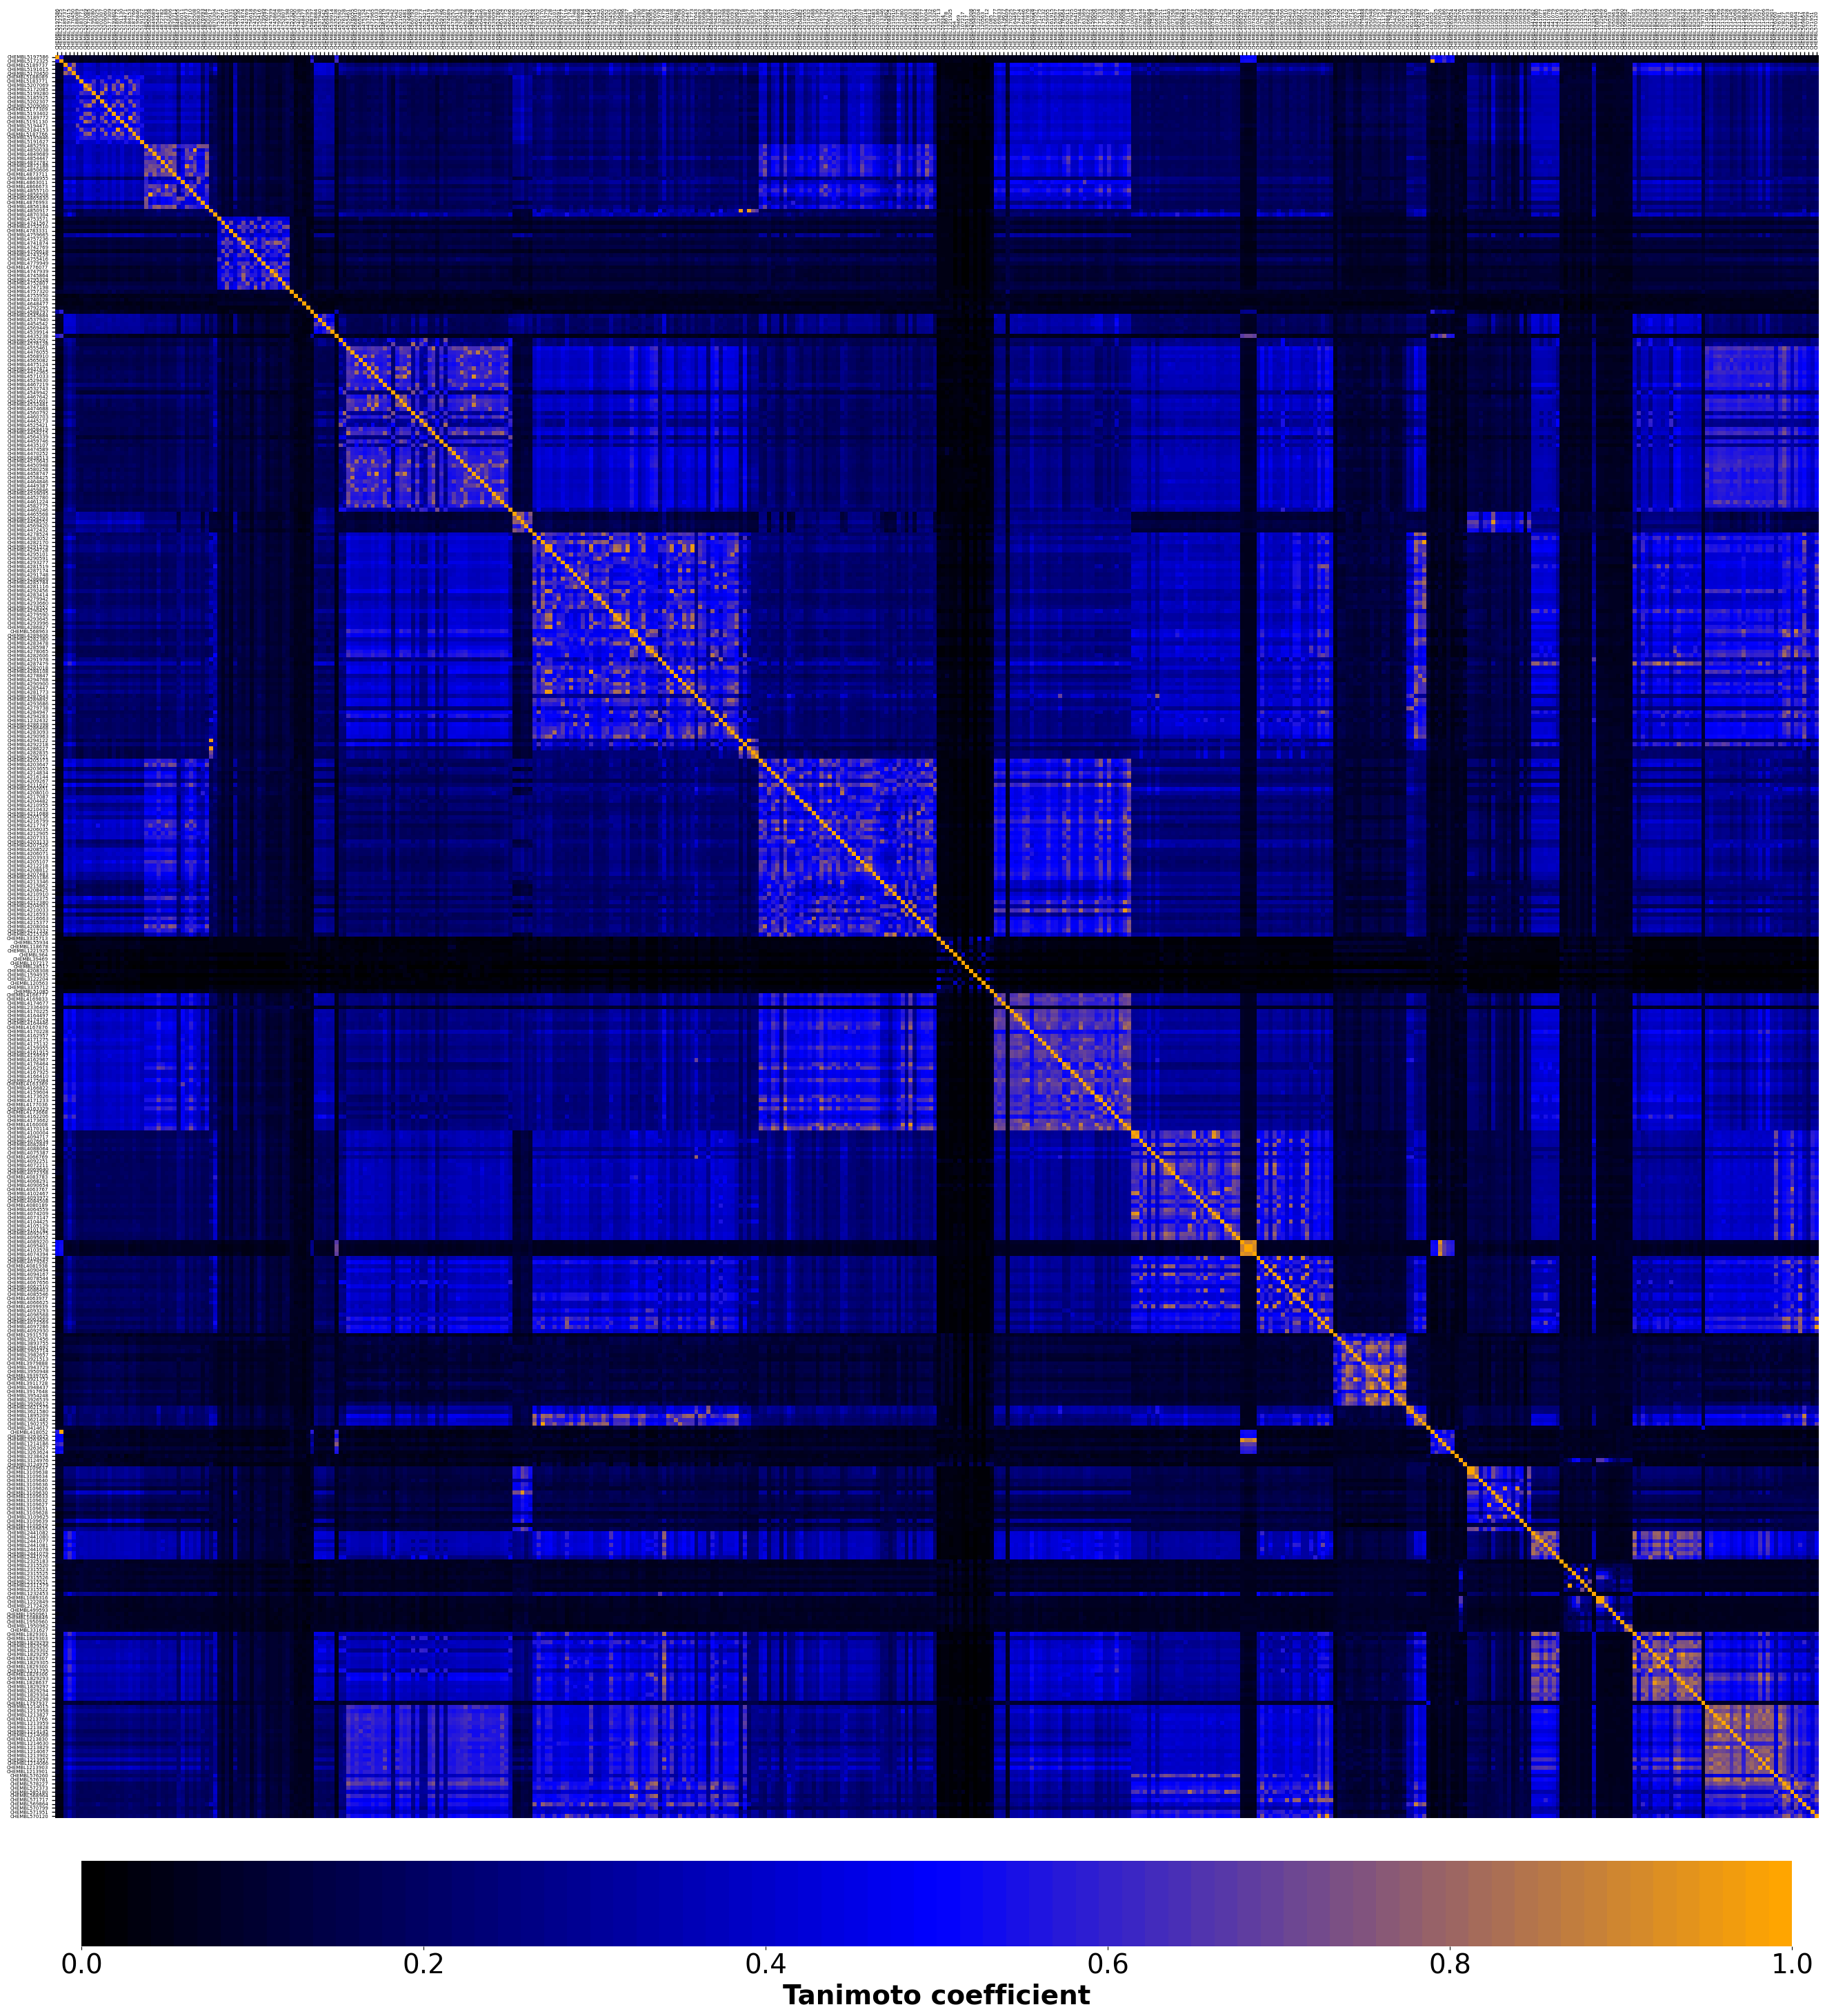

In [ ]:
fig, ax = plt.subplots(figsize=(40,40))
sns.heatmap(hmap,square = True, xticklabels=hmap.columns, yticklabels=hmap.index, cmap=palette, vmin=0, vmax=1,
            cbar_kws={'shrink':0.8,
                      'orientation':'horizontal','spacing':'uniform',
                      'pad':0.02})
ax.figure.axes[1].tick_params(axis="x", labelsize=28) #ticks size in cbar
ax.figure.axes[1].set_xlabel('Tanimoto coefficient', size=28, weight='bold') #cbar label
ax.tick_params(labelsize=28)
plt.xticks (np.arange(len(hmap.index))+0.5, hmap.index,rotation=90)
plt.yticks (np.arange(len(hmap.columns))+0.5, hmap.columns, rotation=0)
ax.xaxis.tick_top()
plt.tick_params ('both',width=1,labelsize=5)
#plt.savefig('Tanimoto_coefficient.png',dpi=300,format='png',transparent=False)
plt.show()

---
# For more information:


* https://projects.volkamerlab.org/teachopencadd/talktorials/T001_query_chembl.html
*   https://gist.github.com/leelasd/746f3c447805fc6ea5aad1071bd77aef

*  https://github.com/rdkit/UGM_2014/blob/master/Notebooks/Scaffold%20analysis%20of%20ChEMBL%20data%20with%20pandas%20and%20RDKit/Scaffold%20analysis%20of%20ChEMBL%20data%20with%20pandas%20and%20RDKit%20-%20RDKit%20UGM2014.ipynb
*  https://github.com/rdkit/UGM_2013/blob/master/Tutorials/pandastools/Pandas_RDKit_UGM.ipynb
* https://github.com/rdkit/UGM_2013/blob/master/Tutorials/pandastools/Pandas_RDKit_UGM.ipynb

